# Detekcija QRS kompleksa u EKG signalu pomoću STFT

In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, signal

def read_ecg(filepath):
    data = np.load(filepath)
    return data["signal"], data["annotation"]

def plot_ecg(ecg, qrs):
    t = len(ecg)/360
    t = np.arange(0, t, 1/360)
    plt.figure()
    plt.plot(t,ecg,'-*',markevery=qrs)

In [5]:
def get(arr, index):
    if index >= 0 and index < len(arr):
        return arr[index]
    return 0

## Učitavanje signala

In [6]:
ecg, annot = read_ecg("ecg/100.npz")

## Stft

In [14]:
f, t, Zxx = signal.stft(ecg, 360, nperseg=75, 
                       window=signal.hamming(75),
                       noverlap=65,
                       boundary='even')

Zxx = np.log(1+20*np.abs(Zxx))

## Brzina promjene

Za brzinu promjene formiramo novi signal, tako što za svaki vremenski trenutak za koji nam stft daje spektar izračunamo energiju spektra. Ovdje sam pokušao sa računanjem spektra sa svim komponentama, ali ispada da se dobije bolji rezultat ako se uzme samo neka od komponenata u opsegu od 5-15Hz. Ovdje ih imamo dvije, 9.6Hz i 14.4Hz, jer se koristi dužina prozora 75, pa se opseg od 360Hz predstavlja preko 75 frekvencija, gdje je korak 360/75, a treća i četvrta frekvencija su 9.6 i 14.4Hz. Ja sam uzeo treću frekvenciju - 9.6Hz.

Za samo računanje izvoda, tj. brzine promjene ovog signala, prva ideja mi je bila da koristim jednostavno formulu $derivative[i] = \frac{y[i+1]-y[i]}{h},$ gdje je h vremenski interval između dva prozora. Zatim sam našao five-point stencil metodu na Vikipediji. Oba načina su dali slične rezultate. Na kraju sam preuzeo derivative filtar iz Pan Tompkins rada. Kašnjenje filtra je 2 odmjerka.

In [15]:
s = np.zeros(len(t))
for i in range(len(t)):
    s[i] = np.abs(Zxx[2][i])**2

x = s.copy()
der = np.zeros(len(x))
#derivative
for i in range(0, len(der)):
    der[i] = ((-get(x, i-2) - 2*get(x,i-1)+2*get(x, i+1)+get(x,i+2))*360)/8

## Nelinearna transformacija

Za nelinearnu transformaciju, razmišljao sam ili o apsolutnoj vrijenosti ili kvadradriranju, na kraju sam izabrao kvadriranje.

In [16]:
nt = der*der

## Demonstracija koraka

### Signal 100

<IPython.core.display.Javascript object>


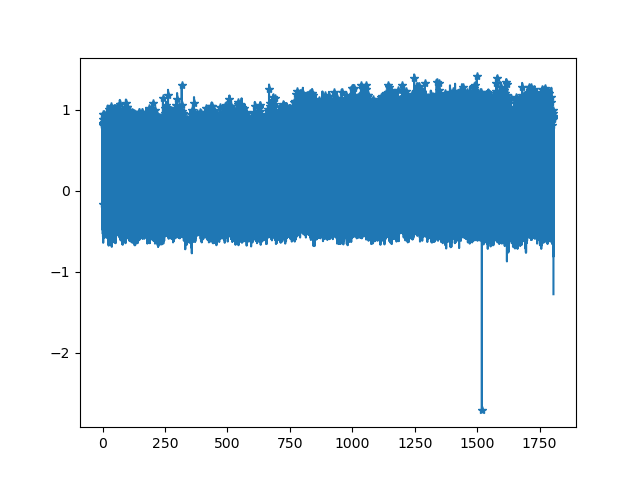

In [7]:
plot_ecg(ecg,annot)

### Spektrogram

<IPython.core.display.Javascript object>


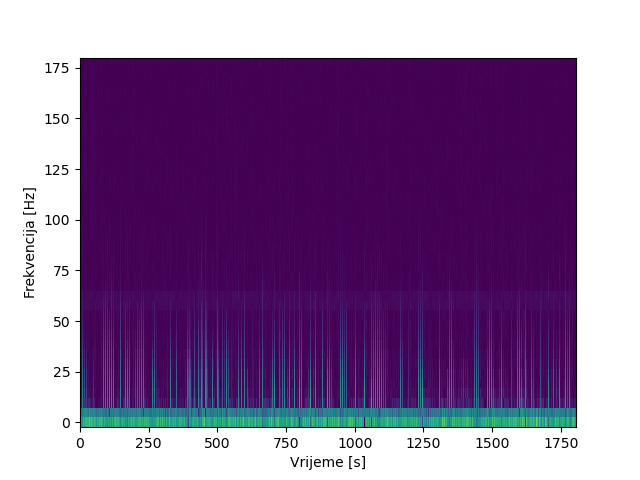

Text(0, 0.5, 'Frekvencija [Hz]')

In [8]:
plt.figure()
plt.pcolormesh(t, f, np.abs(Zxx))

plt.xlabel('Vrijeme [s]')
plt.ylabel('Frekvencija [Hz]')

### Izvod

<IPython.core.display.Javascript object>


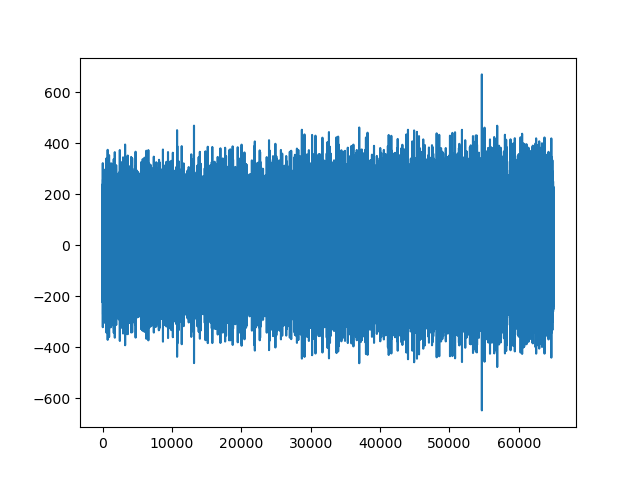

In [17]:
plt.figure()
plt.plot(der)

### Nelinearna transformacija

<IPython.core.display.Javascript object>


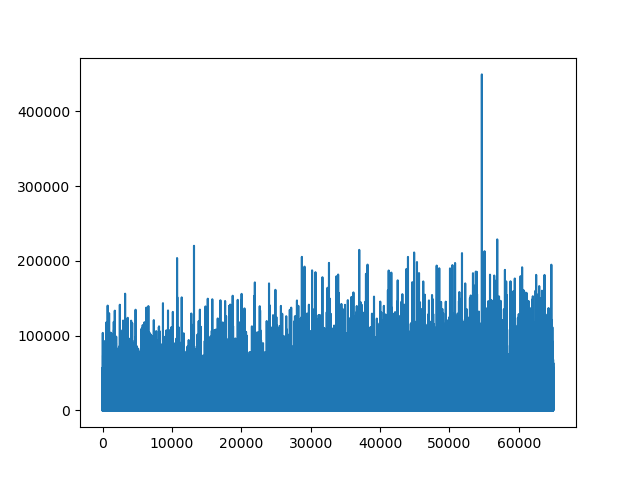

In [24]:
plt.figure()
plt.plot(nt)

## Blok za detekciju kandidata

Prva ideja za detekciju kandidata bila je na osnovu srednje vrijednosti signala, gdje bih našao srednju vrijednost i mjesta koja na kojima se pojavljuje vrijednost veća od srednja vrijednost bi bila kandidati. Poslije sam došao do metode koja se pokazala bolje gdje se za svaki odmjerak, gleda odmjerak prije i odmjerak poslije, i ako su oba manja od trenutnog, računa se kao kandidat. Prije toga primjeni se moving average filtar za potiskivanje manjih promjena.

In [20]:
slopes = signal.fftconvolve(nt, np.full((25,), 1) / 25, mode='same')
slopes=nt
peaks = []
for i in range(1, len(slopes)-1):
    if (slopes[i] > slopes[i-1]) and (slopes[i+1] < slopes[i]):
        peaks.append(i) 

## Blok za odlučivanje

Osim implementacije algoritma iz teksta zadatka, dodatno uklanjam vrhove tako da se ne nalazi više od jednog qrs kompleksa unutar prozora od 200ms. Ako se unutar prozora od 200ms, nalazi više od jednog qrs kompleksa, zadrži se onaj čija je vrijednost veća. Ovaj korak dosta poboljšava preciznost rezultata, dok neznatno smanjuje osjetljivost.

In [22]:
peakIndices = peaks
qrsIndices = []
noiseIndices = []
prag = 0
Lp = 0
Ln = 0
for i in range(0, len(peakIndices)):
    if nt[peakIndices[i]] > prag:
        qrsIndices.append(peakIndices[i])
        Lp = 0.125*Lp + (1-0.125)*nt[peakIndices[i]]
    else:
        noiseIndices.append(peakIndices[i])
        Ln = 0.125*Ln + (1-0.125)*nt[peakIndices[i]]

    prag = Ln+0.25*(Lp-Ln)

window_200ms = round(0.2*360)

tp=[]
fp=[]
fn=[]

#derivative ima kašnjenje 2
for i in range(len(qrsIndices)):
    qrsIndices[i]+=2

#vratimo nazad
for i in range(len(qrsIndices)):
    qrsIndices[i]*=10

low = 0
high = 1
result =[]
window_200ms = round(0.2*360)
found = False
for i in range(len(qrsIndices)):
    for j in range(1, window_200ms+1):
        if qrsIndices[i]-j in result:
            ind = 0
            for k in range(len(result)):
                if result[k] == qrsIndices[i]-j:
                    ind = k
                    break

            found = True
            if qrsIndices[i] < len(ecg) and ecg[qrsIndices[i]] > ecg[qrsIndices[i]-j]:
                result.remove(qrsIndices[i]-j)
                result.append(qrsIndices[i])             
    if not found:
        result.append(qrsIndices[i])

    found = False

qrsIndices = result

### Sve zajedno

In [41]:
def detect(ecg, duzinaProzora, korak, gamma, N):
    
    f, t, Zxx = signal.stft(ecg, 360, nperseg=duzinaProzora, 
                           window=signal.hamming(duzinaProzora),
                           noverlap=duzinaProzora-korak,
                           boundary='even',
                           nfft=N)
    
    Zxx = np.log(1+gamma*np.abs(Zxx))
    
    s = np.zeros(len(t))

    for i in range(len(t)):
        s[i] = np.abs(Zxx[2][i])**2
             
    x = s.copy()
    y = np.zeros(len(x))
    #derivative
    for i in range(0, len(y)):
        y[i] = ((-get(x, i-2) - 2*get(x,i-1)+2*get(x, i+1)+get(x,i+2))*360)/8

    y = y*y
    
    peaks =[]

    slopes = signal.fftconvolve(y, np.full((25,), 1) / 25, mode='same')
    slopes=y
    for i in range(1, len(slopes)-1):
        if (slopes[i] > slopes[i-1]) and (slopes[i+1] < slopes[i]):
            peaks.append(i)  
            
    peakIndices = peaks
    qrsIndices = []
    noiseIndices = []
    prag = 0
    Lp = 0
    Ln = 0
    for i in range(0, len(peakIndices)):
        if y[peakIndices[i]] > prag:
            qrsIndices.append(peakIndices[i])
            Lp = 0.125*Lp + (1-0.125)*y[peakIndices[i]]
        else:
            noiseIndices.append(peakIndices[i])
            Ln = 0.125*Ln + (1-0.125)*y[peakIndices[i]]

        prag = Ln+0.25*(Lp-Ln)
        
    window_200ms = round(0.2*360)
    
    tp=[]
    fp=[]
    fn=[]
    
    #derivative ima kašnjenje 2
    for i in range(len(qrsIndices)):
        qrsIndices[i]+=2
    
    #vratimo nazad
    for i in range(len(qrsIndices)):
        qrsIndices[i]*=10
        
    low = 0
    high = 1
    result =[]
    window_200ms = round(0.2*360)
    found = False
    for i in range(len(qrsIndices)):
        for j in range(1, window_200ms+1):
            if qrsIndices[i]-j in result:
                ind = 0
                for k in range(len(result)):
                    if result[k] == qrsIndices[i]-j:
                        ind = k
                        break

                found = True
                if qrsIndices[i] < len(ecg) and ecg[qrsIndices[i]] > ecg[qrsIndices[i]-j]:
                    result.remove(qrsIndices[i]-j)
                    result.append(qrsIndices[i])             
        if not found:
            result.append(qrsIndices[i])

        found = False
                   
    qrsIndices = result

    tp = 0
    for i in range(len(qrsIndices)):
        for j in [-5,-4,-3,-2,-1,0,1,2,3,4,5]:
            if np.isin(qrsIndices[i]+j, annot):
                tp+=1
                
    fp = len(qrsIndices) - tp

    fn = len(annot) - tp
                
    s = tp/(tp+fn)
    p = tp/(tp+fp)
    
    print(tp,fp,fn)

    return round(s*100,2), round(p*100,2), qrsIndices

## Uticaji parametara

### Mijenjanja broj tacaka fft-a

Zaključaj je da se najbolji rezultat dobije kada je broj tačaka fft-a jednak dužini prozora.

<IPython.core.display.Javascript object>


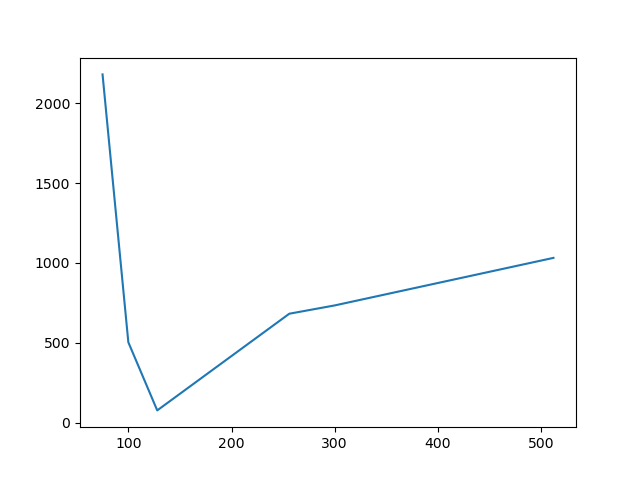

In [13]:
brojTacaka = [75, 100, 128, 256, 300, 512]
result = []
for broj in brojTacaka:
    result.append(detect(ecg, 75,10,20,broj))
    
plt.figure()
plt.plot(brojTacaka, result)

<IPython.core.display.Javascript object>


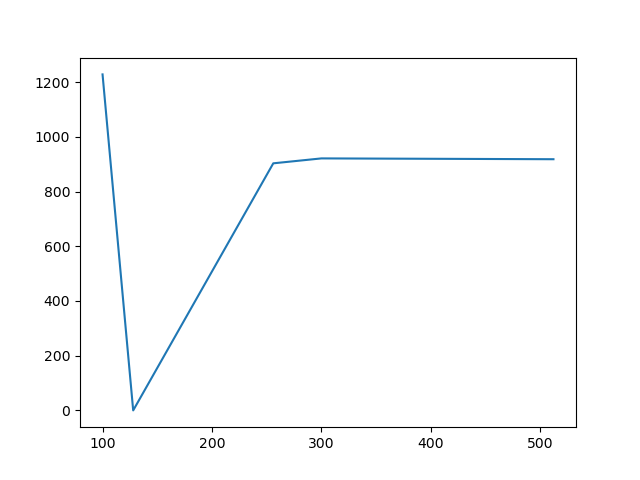

In [15]:
brojTacaka = [100, 128, 256, 300, 512]
result = []
for broj in brojTacaka:
    result.append(detect(ecg, 100,10,20,broj))
    
plt.figure()
plt.plot(brojTacaka, result)

### Mijenjanje dužine prozora

Najbolja duzina prozora 79 za signal 100

1703 570 571
1851 422 423
1769 504 505
1928 345 346
1844 429 430
2000 273 274
1919 354 355
2071 202 203
2001 272 273
2140 133 134
2076 197 198
2182 91 92
2143 130 131
2212 61 62
2193 79 81
2221 51 53


<IPython.core.display.Javascript object>


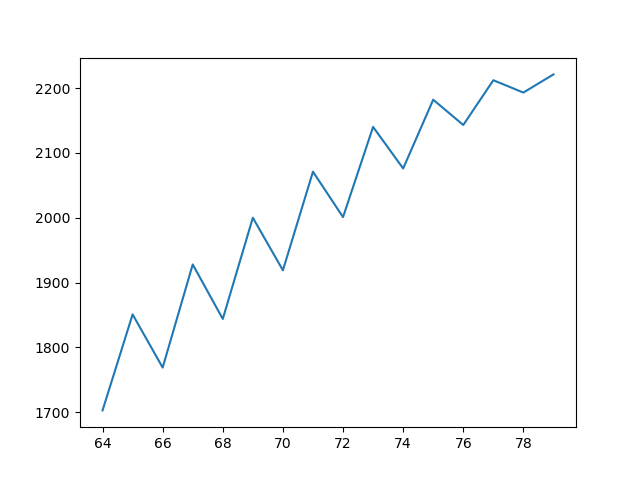

In [19]:
duzinaProzora = [x for x in range(64,80)]
result = []
for duzina in duzinaProzora:
    result.append(detect(ecg, duzina,10,20,duzina))
plt.figure()
plt.plot(duzinaProzora, result)

2214 58 60
2175 97 99
2207 62 67
2098 171 176
2141 126 133
1995 271 279
2068 198 206
1897 369 377
1936 330 338
1797 468 477


<IPython.core.display.Javascript object>


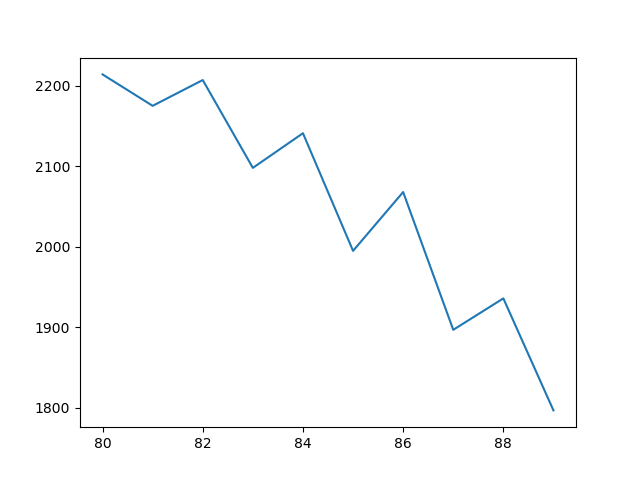

In [20]:
duzinaProzora = [x for x in range(80,90)]
result = []
for duzina in duzinaProzora:
    result.append(detect(ecg, duzina,10,20,duzina))
plt.figure()
plt.plot(duzinaProzora, result)

### Mijenjanje duzine preklapanja
Najbolja duzina preklapanja je 10 za signal 100 i duzinu prozora 79

16 4530 2258
37 4509 2237
44 4501 2230
74 4470 2200
77 4459 2197
107 2183 2167
104 2169 2170
145 2125 2129
153 2119 2121
2221 51 53
165 2107 2109
154 2115 2120
163 2106 2111
173 2096 2101
170 2101 2104
160 2100 2114
160 2099 2114
174 2091 2100
171 2079 2103


<IPython.core.display.Javascript object>


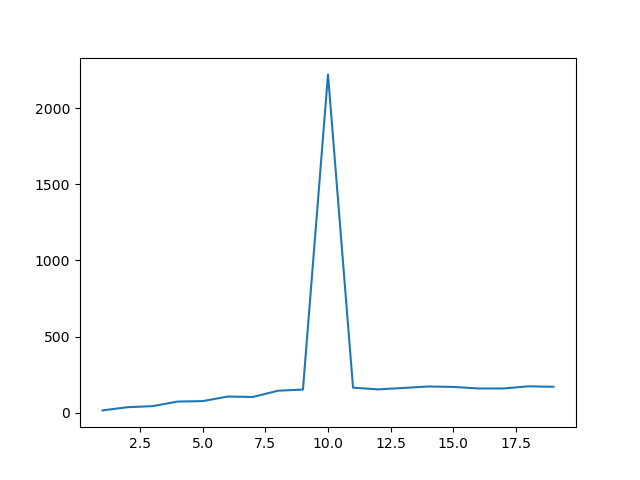

In [21]:
duzinaPreklapanja = [x for x in range(1,20)]
result = []
for duzina in duzinaPreklapanja:
    result.append(detect(ecg, 79,duzina,20,79))
plt.figure()
plt.plot(duzinaPreklapanja, result)

### Mijenjanje parametra gamma

Najbolji rezultat za gamma = 20, pri duzini prozora 79 i duzini preklapanja 10

1880 334 394
2115 143 159
2203 66 71
2221 51 53
2178 95 96
2115 158 159
2055 218 219
2011 262 263
1954 320 320
1918 356 356
1881 393 393
1850 424 424
1832 442 442
1807 467 467
1778 496 496
1751 523 523
1727 547 547
1704 570 570
1686 588 588


<IPython.core.display.Javascript object>


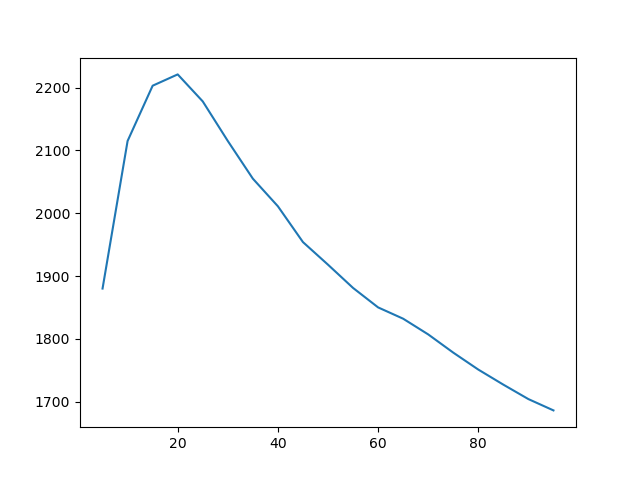

In [24]:
gamma = [x for x in range(5,100,5)]
result = []
for g in gamma:
    result.append(detect(ecg, 79,10,g,79))
plt.figure()
plt.plot(gamma, result)

## Ocjena performansi

### Duzina prozora 79

In [29]:
import os
directory="ecg"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    ecg, annot = read_ecg(f)
    print(filename, detect(ecg,79,10,20,79))

2221 51 53
100.npz 2221
1762 676 378
107.npz 1762
822 995 1002
108.npz 822
1659 243 137
113.npz 1659
445 1091 1094
117.npz 445
1663 326 431
119.npz 1663
1883 593 596
122.npz 1883
1912 815 1196
203.npz 1912
204 1977 2181
207.npz 204
2204 225 258
221.npz 2204


### Duzina prozora 75

In [37]:
import os
directory="ecg"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    ecg, annot = read_ecg(f)
    print(filename, detect(ecg,75,10,20,75))

2182 91 92
100.npz (95.95, 96.0)
1851 493 289
107.npz (86.5, 78.97)
849 960 975
108.npz (46.55, 46.93)
1782 54 14
113.npz (99.22, 97.06)
468 1068 1071
117.npz (30.41, 30.47)
1762 227 332
119.npz (84.15, 88.59)
2100 376 379
122.npz (84.71, 84.81)
2012 740 1096
203.npz (64.74, 73.11)
206 1963 2179
207.npz (8.64, 9.5)
2333 92 129
221.npz (94.76, 96.21)


Iako je dužina prozora 79 bolja za signal 100, ukupno je bolja dužina prozora 75 za sve signale.

### Ocjena performansi za dužinu prozora 75, dužina preklapanja 10, gamma 20, nfft 75

| Signal  | Tp   | Fp  | Fn  | Osjetljivost | Preciznost |
| ------  | --   | --  | --  | ------------ | ---------- |
| 100     | 2182 | 91  | 92  | 95.95%       | 96.0%      |
| 107     | 1851 | 493 | 289 | 86.5%        | 78.97%     |
| 108     | 849  | 960 | 975 | 46.55%       | 46.93%     |
| 113     | 1782 | 54  | 14  | 99.22%       | 97.06%     |
| 117     | 468  | 1068| 1071| 30.41%       | 30.47%     |
| 119     | 1762 | 227 | 332 | 84.15%       | 88.59%     |
| 122     | 2100 | 376 | 379 | 84.71%       | 84.81%     |
| 203     | 2012 | 740 | 1096| 64.74%       | 73.11%     |
| 207     | 206  | 1963| 2179| 8.64%        | 9.5%       |
| 221     | 2333 | 92  | 129 | 94.76%       | 96.21%     |

### Primjer dobro detektovanog signala - signal 113

1782 54 14


<IPython.core.display.Javascript object>


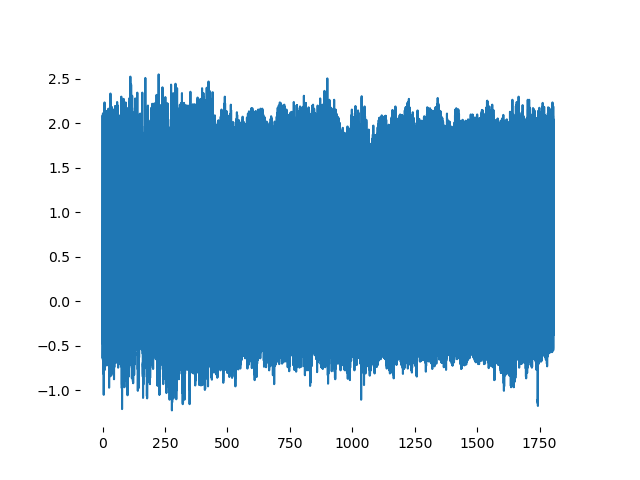

In [50]:
ecg, annot = read_ecg("ecg/113.npz")
s,p,indices = detect(ecg, 75,10,20,75)
plot_ecg(ecg,indices)

### Primjer loše detektovanog signala - signal 207

206 1963 2179


<IPython.core.display.Javascript object>


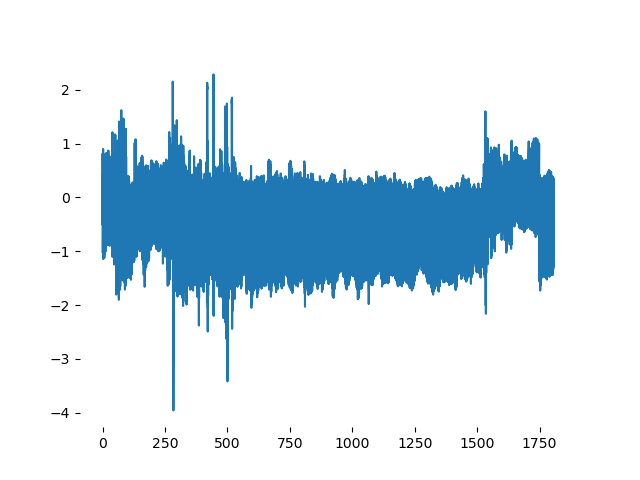

In [53]:
ecg, annot = read_ecg("ecg/207.npz")
s,p,indices = detect(ecg, 75,10,20,75)
plot_ecg(ecg,np.array(indices))

## Dodatna poboljšanja

Osim samo treće frekvencijeske komponente mogli bismo da gledamo i četvrtu komponentu. U Pan Tompkins radu, jedan od metoda za dodatnu detekciju je da se prati prosječan interval između dva R talasa, pa ako se ne pronađe nijedan qrs kompleks u tom intervalu, izabere se odmjerak sa najvećom vrijednošću u tom intervalu za qrs kompleks. Takođe, može se dodati provjerava da li je detektovani r talas, zapravo t talas.